In [85]:
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)

In [86]:
# !cp '/content/drive/MyDrive/spectrograms.zip' .

In [87]:
# !unzip -q spectrograms.zip

In [88]:
# !pip list

In [89]:
# !rm -r /content/logs

In [90]:
import keras.callbacks
import tensorflow as tf
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from tensorflow.keras.utils import Sequence
import math
import pandas as pd
import random
from tensorflow.keras import models, layers, callbacks, activations

import librosa
import librosa.display

import warnings

import pickle

AUTOTUNE = tf.data.AUTOTUNE

# tf.config.run_functions_eagerly(True)

In [91]:
SAMPLE_RATE = 24000
FREQ_SIZE = 188
SECONDS = 4

N_MFCC = 100

BATCH_SIZE_TRAIN = 50
BATCH_SIZE_TEST = 1
BATCH_SIZE_VAL = 50
EPOCHS = 50

NUM_TRAIN = 2250
NUM_VAL = 500
NUM_TEST = 250

STEPS_PER_EPOCH = NUM_TRAIN // BATCH_SIZE_TRAIN

# LABELS_FR = ['zéro','un','deux','trois','quatre','cinq','six','sept','huit','neuf','dix','Hey','oui','non','Firefox']

# NUM_LABELS_FR = len(LABELS_FR)
NUM_LANGUAGES = 1
LANGUAGES = ['EN','ES']

LOG_DIR = "/content/logs/model" + str(NUM_LANGUAGES) + "-"

SEED = 0
tf.random.set_seed(SEED)
np.random.seed(SEED)

LEARNING_RATE = 0.0001

In [92]:
BASE_DIR_EN = '/content/spectrograms/en/clips/'
TRAIN_PATH_EN = '/content/spectrograms/en/train.tsv'
TEST_PATH_EN = '/content/spectrograms/en/test.tsv'
VAL_PATH_EN = '/content/spectrograms/en/val.tsv'

NUM_TRAIN_EN = NUM_TRAIN
NUM_VAL_EN = NUM_VAL
NUM_TEST_EN = NUM_TEST

LABELS_EN = ['zero','one','two','three','four','five','six','seven','eight','nine','ten','Hey','yes','no','Firefox']
NUM_LABELS_EN = len(LABELS_EN)

In [93]:
BASE_DIR_ES = '/content/spectrograms/es/clips/'
TRAIN_PATH_ES = '/content/spectrograms/es/train.tsv'
TEST_PATH_ES = '/content/spectrograms/es/test.tsv'
VAL_PATH_ES = '/content/spectrograms/es/val.tsv'

NUM_TRAIN_ES = NUM_TRAIN
NUM_VAL_ES = NUM_VAL
NUM_TEST_ES = NUM_TEST

LABELS_ES = ['cero','cinco','cuatro','dos','Firefox','Hey','no','neuve','ocho','seis','siete','tres','uno','sí']
NUM_LABELS_ES = len(LABELS_ES)

In [94]:
def padaudio(waveform):
    if (len(waveform) >= SAMPLE_RATE * SECONDS):
        return waveform
    else:
        return np.pad(waveform,(0,SAMPLE_RATE * SECONDS - len(waveform)),mode='constant', constant_values=(0,0))

# def processdata(file):
#     waveform,sample_rate = librosa.load(file, SAMPLE_RATE)
#     waveform = padaudio(waveform)
#     mfccs = librosa.feature.mfcc(waveform,sr=sample_rate,n_mfcc=N_MFCC)
#     mfccs = np.moveaxis(mfccs,1,0)
#     scaler = StandardScaler()
#     mfccs_scaled = scaler.fit_transform(mfccs)
#     return mfccs_scaled.reshape(mfccs_scaled.shape[0], mfccs_scaled.shape[1],1)

def processdata(file):
  filename = file.split(".")[0] + '.pkl'
  with open(filename,'rb') as f:
    spectrogram = pickle.load(f)

  return spectrogram

In [95]:
def getlabel(onehot,labels):
    index = np.argmax(onehot)
    label = labels[index]
    return label

def getonehot(label,labels):
    onehot = np.array([1 if x == label else 0 for x in labels])
    return onehot

In [96]:
def getdata(df,base_dir):
    df['fullpath'] = base_dir + df['path']
    inputs = df['fullpath'].tolist()
    labels = df['sentence'].tolist()
    x = np.array(inputs)
    y = np.array(labels)
    return x,y

In [97]:
dftrainEN = pd.read_csv(TRAIN_PATH_EN, sep='\t', header=0)
dftrainEN.sort_values(by='length',ascending=False,inplace=True)
trainxEN,trainyEN, = getdata(dftrainEN.head(NUM_TRAIN_EN), BASE_DIR_EN)

dfvalEN = pd.read_csv(VAL_PATH_EN, sep='\t', header=0)
dfvalEN.sort_values(by='length',ascending=False,inplace=True)
valxEN,valyEN, = getdata(dfvalEN.head(NUM_VAL_EN), BASE_DIR_EN)

dftestEN = pd.read_csv(TEST_PATH_EN, sep='\t', header=0)
dftestEN.sort_values(by='length',ascending=False,inplace=True)
testxEN,testyEN, = getdata(dftestEN.head(NUM_TEST_EN), BASE_DIR_EN)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [98]:
dftrainES = pd.read_csv(TRAIN_PATH_ES, sep='\t', header=0)
dftrainES.sort_values(by='length',ascending=False,inplace=True)
trainxES,trainyES, = getdata(dftrainES.head(NUM_TRAIN_ES), BASE_DIR_ES)

dfvalES = pd.read_csv(VAL_PATH_ES, sep='\t', header=0)
dfvalES.sort_values(by='length',ascending=False,inplace=True)
valxES,valyES, = getdata(dfvalES.head(NUM_VAL_ES), BASE_DIR_ES)

dftestES = pd.read_csv(TEST_PATH_ES, sep='\t', header=0)
dftestES.sort_values(by='length',ascending=False,inplace=True)
testxES,testyES, = getdata(dftestES.head(NUM_TEST_ES), BASE_DIR_ES)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [99]:
def maketraingenerator(trainxs, trainys):
    def traingenerator():
        for i in range(len(trainxEN)):
            xs = []
            ys = []

            for trainx,trainy in zip(trainxs,trainys):
                with warnings.catch_warnings():
                    warnings.simplefilter("ignore")
                    xs.append(processdata(trainx[i]))
                ys.append(getonehot(trainy[0][i],trainy[1]))

            xst = tuple(xs)
            yst = tuple(ys)
            yield xst,yst
    return traingenerator


xtypes = tuple([tf.float32]*NUM_LANGUAGES)
ytypes = tuple([tf.int32]*NUM_LANGUAGES)
traingentypes = (xtypes,ytypes)

xshapes = tuple([[FREQ_SIZE,N_MFCC,1] for i in range(NUM_LANGUAGES)])
yshapes = tuple([[15]])
traingenshapes = (xshapes,yshapes)

In [100]:
def makevalgenerator(trainxs, trainys):
    def traingenerator():
        for i in range(len(valxEN)):
            xs = []
            ys = []

            for trainx,trainy in zip(trainxs,trainys):
                with warnings.catch_warnings():
                    warnings.simplefilter("ignore")
                    xs.append(processdata(trainx[i]))
                ys.append(getonehot(trainy[0][i],trainy[1]))

            xst = tuple(xs)
            yst = tuple(ys)
            yield xst,yst
    return traingenerator

In [101]:
trainxsEN = [trainxEN]
trainysEN = [[trainyEN,LABELS_EN]]

trainxsES = [trainxES]
trainysES = [[trainyES,LABELS_ES]]

valxsEN = [valxEN]
valysEN = [[valyEN,LABELS_EN]]

valxsES = [valxES]
valysES = [[valyES,LABELS_ES]]


In [103]:
def maketestgenerator(testx,testy,labels):
    def testgenerator():
        for i in range(len(testx)):
            x = processdata(testx[i])
            y = getonehot(testy[i],labels)
            yield x,y
    return testgenerator

testgentypes = (tf.float32,tf.int32)
testgenshapes = ([FREQ_SIZE,N_MFCC,1],[15])

In [104]:
traindatasetEN = tf.data.Dataset.from_generator(maketraingenerator(trainxsEN,trainysEN),output_types=traingentypes,output_shapes=traingenshapes)
traindatasetEN = traindatasetEN.shuffle(NUM_TRAIN_EN)
traindatasetEN = traindatasetEN.batch(BATCH_SIZE_TRAIN)
traindatasetEN = traindatasetEN.repeat(-1)
traindatasetEN = traindatasetEN.cache().prefetch(AUTOTUNE)

valdatasetEN = tf.data.Dataset.from_generator(makevalgenerator(valxsEN,valysEN),output_types=traingentypes,output_shapes=traingenshapes)
valdatasetEN = valdatasetEN.batch(BATCH_SIZE_VAL)
valdatasetEN = valdatasetEN.cache().prefetch(AUTOTUNE)

testdatasetEN = tf.data.Dataset.from_generator(maketestgenerator(testxEN,testyEN,LABELS_EN),output_types=testgentypes,output_shapes=testgenshapes)
testdatasetEN = testdatasetEN.batch(BATCH_SIZE_TEST)

In [105]:
traindatasetES = tf.data.Dataset.from_generator(maketraingenerator(trainxsES,trainysES),output_types=traingentypes,output_shapes=(xshapes,tuple([[14]])))
traindatasetES = traindatasetES.shuffle(NUM_TRAIN_ES)
traindatasetES = traindatasetES.batch(BATCH_SIZE_TRAIN)
traindatasetES = traindatasetES.repeat(-1)
traindatasetES = traindatasetES.cache().prefetch(AUTOTUNE)

valdatasetES = tf.data.Dataset.from_generator(makevalgenerator(valxsES,valysES),output_types=traingentypes,output_shapes=(xshapes,tuple([[14]])))
valdatasetES = valdatasetES.batch(BATCH_SIZE_VAL)
valdatasetES = valdatasetES.cache().prefetch(AUTOTUNE)

testdatasetES = tf.data.Dataset.from_generator(maketestgenerator(testxES,testyES,LABELS_ES),output_types=testgentypes,output_shapes=([FREQ_SIZE,N_MFCC,1],[14]))
testdatasetES = testdatasetES.batch(BATCH_SIZE_TEST)


In [108]:
def languagelayers(num_labels,language):
        lang = keras.Sequential([
        layers.Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding='same', activation=activations.relu, name=language+'_Conv2D1'),
        layers.MaxPooling2D(pool_size=(2,2), strides=(2,2), name=language+'_MaxPool2D1'),
        # layers.Conv2D(filters=512, kernel_size=(3,3), padding='same', activation=activations.relu, name=language+'_Conv2D2'),
        # layers.MaxPooling2D(pool_size=(3,3), strides=(2,2), name=language+'_MaxPool2D2'),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(128, activation=activations.relu, name=language+'_DenseLayer1'),
        layers.Dropout(0.5),
        layers.Dense(128, activation=activations.relu, name=language+'_DenseLayer2'),
        layers.Dropout(0.5),
        layers.Dense(num_labels, activation=activations.softmax, name=language+'_Output')
        ],
        name=language)

        return lang

Model: "Full_Model_EN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 EN_Input (InputLayer)       [(None, 188, 100, 1)]     0         
                                                                 
 Shared_Layers (Sequential)  (None, 10, 5, 128)        127744    
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| Shared_Conv2D1 (Conv2D)   (None, 94, 50, 32)        2624      |
|                                                               |
| Shared_MaxPool2D1 (MaxPooli  (None, 46, 24, 32)     0         |
| ng2D)                                                         |
|                                                               |
| Shared_Conv2D2 (Conv2D)   (None, 46, 24, 64)        51264     |
|                                                               |
| Shared_MaxPool2D2 (MaxPooli  (None, 22, 11, 64)     0         |
| ng2D)                                              

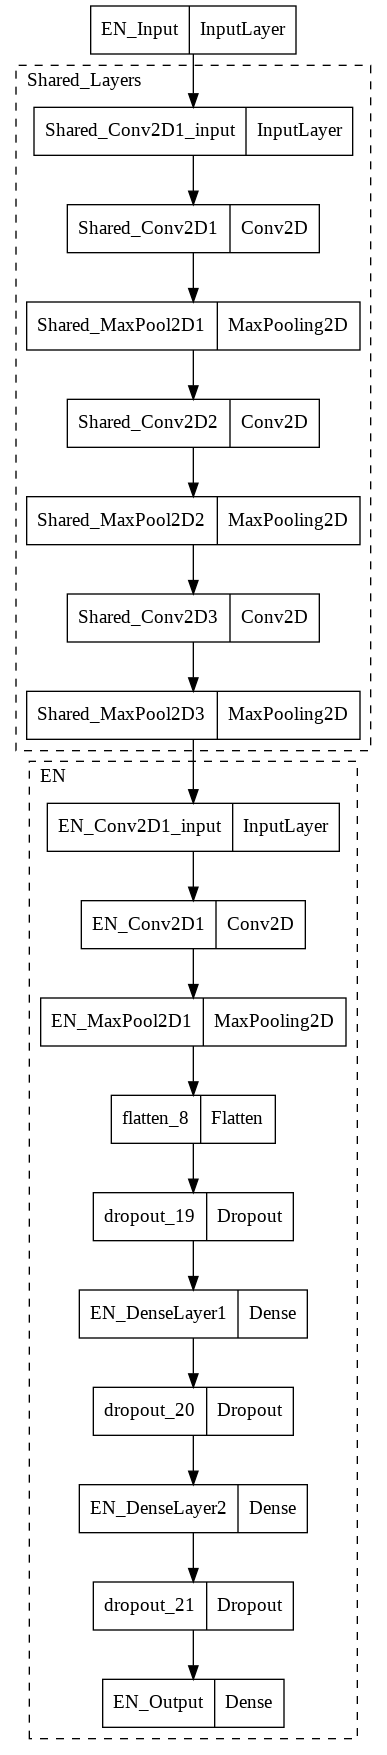

In [109]:
inputEN = tf.keras.Input(shape=(FREQ_SIZE,N_MFCC,1),name='EN_Input')
inputES = tf.keras.Input(shape=(FREQ_SIZE,N_MFCC,1),name='ES_Input')

shared = keras.Sequential([
    layers.Conv2D(filters=32, kernel_size=(9,9), strides=(2,2), padding='same', activation=activations.relu, name='Shared_Conv2D1'),
    layers.MaxPooling2D(pool_size=(3,3), strides=(2,2), name='Shared_MaxPool2D1'),
    layers.Conv2D(filters=64, kernel_size=(5,5), strides=(1,1), padding='same', activation=activations.relu, name='Shared_Conv2D2'),
    layers.MaxPooling2D(pool_size=(3,3), strides=(2,2), name='Shared_MaxPool2D2'),
    layers.Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding='same', activation=activations.relu, name='Shared_Conv2D3'),
    layers.MaxPooling2D(pool_size=(3,3), strides=(2,2), name='Shared_MaxPool2D3')
    ],
    name='Shared_Layers'
)

sharedLayersEN = shared(inputEN)
sharedLayersES = shared(inputES)

layersEN = languagelayers(NUM_LABELS_EN,'EN')(sharedLayersEN)
layersES = languagelayers(NUM_LABELS_ES,'ES')(sharedLayersES)


modelFullEN = tf.keras.Model(
    inputs=[inputEN],
    outputs=[layersEN],
    name='Full_Model_EN'
)


modelFullEN.summary(expand_nested=True)
tf.keras.utils.plot_model(modelFullEN, expand_nested=True)

In [110]:
modelFullEN.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss=[tf.keras.losses.CategoricalCrossentropy()],
    metrics=[tf.keras.metrics.CategoricalAccuracy(name='Categorical_Accuracy'), tf.keras.metrics.AUC(name='AUC')]
)

In [111]:
RUN = '1'

ext = '-FULL-EN'

training_callbackFULLEN = callbacks.TensorBoard(log_dir=LOG_DIR + RUN + ext)
reduce_lr_callback = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3,min_lr=1e-5,verbose=1)
earlystopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [112]:
# model.predict(testdatasetEN)

In [113]:
historyEN = modelFullEN.fit(
    x = traindatasetEN,
    validation_data = valdatasetEN,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[training_callbackFULLEN,earlystopping_callback,reduce_lr_callback],
    verbose=1
)


Epoch 1/50
45/45 [==============================] - 53s 1s/step - loss: 2.7245 - Categorical_Accuracy: 0.0667 - AUC: 0.5226 - val_loss: 2.6912 - val_Categorical_Accuracy: 0.1060 - val_AUC: 0.5497 - lr: 1.0000e-04
Epoch 2/50
45/45 [==============================] - 43s 956ms/step - loss: 2.7024 - Categorical_Accuracy: 0.0911 - AUC: 0.5339 - val_loss: 2.6839 - val_Categorical_Accuracy: 0.1060 - val_AUC: 0.5708 - lr: 1.0000e-04
Epoch 3/50
45/45 [==============================] - 42s 929ms/step - loss: 2.6864 - Categorical_Accuracy: 0.1031 - AUC: 0.5575 - val_loss: 2.6731 - val_Categorical_Accuracy: 0.1060 - val_AUC: 0.5596 - lr: 1.0000e-04
Epoch 4/50
45/45 [==============================] - 42s 941ms/step - loss: 2.6884 - Categorical_Accuracy: 0.0987 - AUC: 0.5523 - val_loss: 2.6765 - val_Categorical_Accuracy: 0.1060 - val_AUC: 0.5607 - lr: 1.0000e-04
Epoch 5/50
45/45 [==============================] - 42s 943ms/step - loss: 2.6764 - Categorical_Accuracy: 0.1187 - AUC: 0.5620 - val_loss: 

In [114]:
# print(modelFullEN.layers[-2].weights)

Model: "Full_Model_ES"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 ES_Input (InputLayer)       [(None, 188, 100, 1)]     0         
                                                                 
 Shared_Layers (Sequential)  (None, 10, 5, 128)        127744    
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| Shared_Conv2D1 (Conv2D)   (None, 94, 50, 32)        2624      |
|                                                               |
| Shared_MaxPool2D1 (MaxPooli  (None, 46, 24, 32)     0         |
| ng2D)                                                         |
|                                                               |
| Shared_Conv2D2 (Conv2D)   (None, 46, 24, 64)        51264     |
|                                                               |
| Shared_MaxPool2D2 (MaxPooli  (None, 22, 11, 64)     0         |
| ng2D)                                              

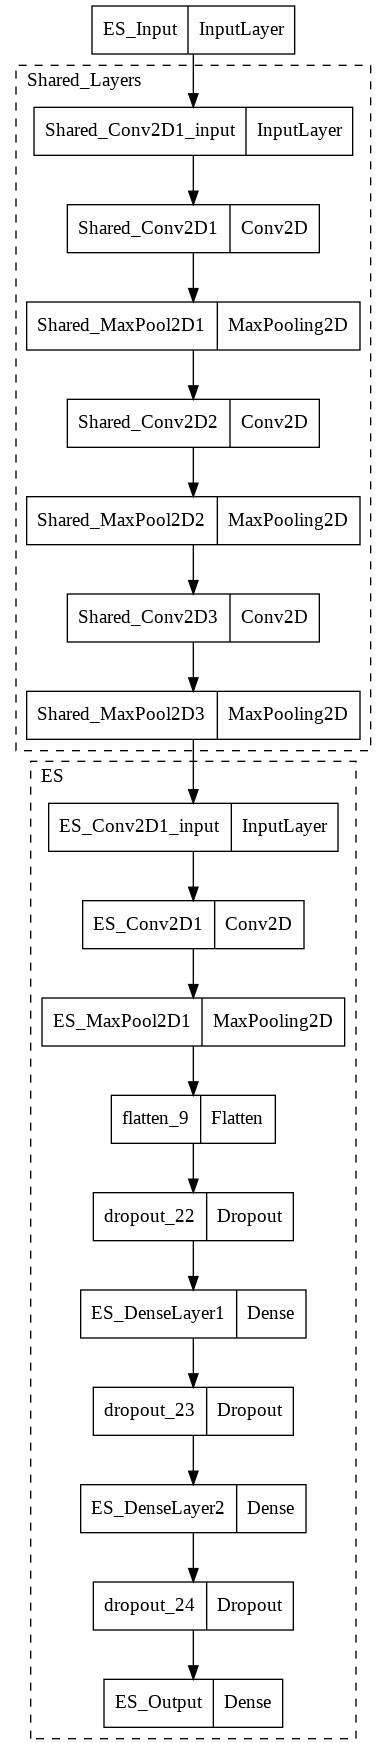

In [115]:
modelFullES = tf.keras.Model(
    inputs=[inputES],
    outputs=[layersES],
    name='Full_Model_ES'
)

modelFullES.summary(expand_nested=True)
tf.keras.utils.plot_model(modelFullES, expand_nested=True)

In [116]:
modelFullES.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss=[tf.keras.losses.CategoricalCrossentropy()],
    metrics=[tf.keras.metrics.CategoricalAccuracy(name='Categorical_Accuracy'), tf.keras.metrics.AUC(name='AUC')]
)

In [117]:
# print(modelFullES.layers[-2].weights)

In [118]:
ext = '-FULL-ES'
training_callbackFULLES = callbacks.TensorBoard(log_dir=LOG_DIR + RUN + ext)

historyES = modelFullES.fit(
    x = traindatasetES,
    validation_data = valdatasetES,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[training_callbackFULLES,earlystopping_callback,reduce_lr_callback],
    verbose=1
)

Epoch 1/50
45/45 [==============================] - 49s 955ms/step - loss: 2.4997 - Categorical_Accuracy: 0.0729 - AUC: 0.5119 - val_loss: 2.4322 - val_Categorical_Accuracy: 0.0960 - val_AUC: 0.5829 - lr: 1.0000e-04
Epoch 2/50
45/45 [==============================] - 42s 928ms/step - loss: 2.4355 - Categorical_Accuracy: 0.0764 - AUC: 0.5438 - val_loss: 2.4156 - val_Categorical_Accuracy: 0.1160 - val_AUC: 0.6310 - lr: 1.0000e-04
Epoch 3/50
45/45 [==============================] - 42s 931ms/step - loss: 2.4043 - Categorical_Accuracy: 0.0964 - AUC: 0.5853 - val_loss: 2.3894 - val_Categorical_Accuracy: 0.1880 - val_AUC: 0.6934 - lr: 1.0000e-04
Epoch 4/50
45/45 [==============================] - 42s 930ms/step - loss: 2.3699 - Categorical_Accuracy: 0.1058 - AUC: 0.6164 - val_loss: 2.3404 - val_Categorical_Accuracy: 0.1900 - val_AUC: 0.7295 - lr: 1.0000e-04
Epoch 5/50
45/45 [==============================] - 42s 937ms/step - loss: 2.3146 - Categorical_Accuracy: 0.1253 - AUC: 0.6585 - val_los

In [119]:
shared.trainable = False

In [120]:
newSharedLayers = shared(inputEN)
newLayersEN = languagelayers(NUM_LABELS_EN,'EN')(newSharedLayers)

modelENRetrain = tf.keras.Model(
    inputs=inputEN,
    outputs=newLayersEN,
    name='ENModelRetrained'
)

In [121]:
modelENRetrain.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=[tf.keras.metrics.CategoricalAccuracy(name='Categorical Accuracy'),tf.keras.metrics.AUC(name='AUC')])

# modelEN.evaluate(testdatasetEN)

In [122]:
ext = '-RETRAIN-EN'
training_callbackRETRAINEN = callbacks.TensorBoard(log_dir=LOG_DIR + RUN + ext)

historyENRetrain = modelENRetrain.fit(
    x = traindatasetEN,
    validation_data = valdatasetEN,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[training_callbackRETRAINEN,earlystopping_callback,reduce_lr_callback],
    verbose=1
)

Epoch 1/50
45/45 [==============================] - 21s 309ms/step - loss: 2.8684 - Categorical Accuracy: 0.0942 - AUC: 0.5490 - val_loss: 2.6518 - val_Categorical Accuracy: 0.1360 - val_AUC: 0.6185 - lr: 1.0000e-04
Epoch 2/50
45/45 [==============================] - 13s 296ms/step - loss: 2.6979 - Categorical Accuracy: 0.0902 - AUC: 0.5789 - val_loss: 2.6206 - val_Categorical Accuracy: 0.2040 - val_AUC: 0.6980 - lr: 1.0000e-04
Epoch 3/50
45/45 [==============================] - 13s 301ms/step - loss: 2.6239 - Categorical Accuracy: 0.1147 - AUC: 0.6170 - val_loss: 2.5525 - val_Categorical Accuracy: 0.1860 - val_AUC: 0.7231 - lr: 1.0000e-04
Epoch 4/50
45/45 [==============================] - 13s 301ms/step - loss: 2.5484 - Categorical Accuracy: 0.1587 - AUC: 0.6601 - val_loss: 2.4588 - val_Categorical Accuracy: 0.2300 - val_AUC: 0.7860 - lr: 1.0000e-04
Epoch 5/50
45/45 [==============================] - 13s 300ms/step - loss: 2.4497 - Categorical Accuracy: 0.1889 - AUC: 0.6985 - val_los

In [123]:
# print(modelENRetrain.layers[-2].weights)

In [124]:
newSharedLayers = shared(inputES)
newLayersES = languagelayers(NUM_LABELS_ES,'ES')(newSharedLayers)

modelESRetrain = tf.keras.Model(
    inputs=inputES,
    outputs=newLayersES,
    name='ESModelRetrained'
)

modelESRetrain.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=[tf.keras.metrics.CategoricalAccuracy(name='Categorical Accuracy'),tf.keras.metrics.AUC(name='AUC')])

ext = '-RETRAIN-ES'
training_callbackRETRAINES = callbacks.TensorBoard(log_dir=LOG_DIR + RUN + ext)

historyESRetrain = modelESRetrain.fit(
    x = traindatasetES,
    validation_data = valdatasetES,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[training_callbackRETRAINES,earlystopping_callback,reduce_lr_callback],
    verbose=1
)

Epoch 1/50
45/45 [==============================] - 18s 314ms/step - loss: 2.6570 - Categorical Accuracy: 0.0920 - AUC: 0.5319 - val_loss: 2.3774 - val_Categorical Accuracy: 0.1760 - val_AUC: 0.6744 - lr: 1.0000e-04
Epoch 2/50
45/45 [==============================] - 14s 303ms/step - loss: 2.4191 - Categorical Accuracy: 0.1133 - AUC: 0.5866 - val_loss: 2.3455 - val_Categorical Accuracy: 0.2060 - val_AUC: 0.7505 - lr: 1.0000e-04
Epoch 3/50
45/45 [==============================] - 13s 301ms/step - loss: 2.3669 - Categorical Accuracy: 0.1191 - AUC: 0.6208 - val_loss: 2.2938 - val_Categorical Accuracy: 0.2120 - val_AUC: 0.7977 - lr: 1.0000e-04
Epoch 4/50
45/45 [==============================] - 14s 306ms/step - loss: 2.2877 - Categorical Accuracy: 0.1431 - AUC: 0.6715 - val_loss: 2.2024 - val_Categorical Accuracy: 0.2340 - val_AUC: 0.8355 - lr: 1.0000e-04
Epoch 5/50
45/45 [==============================] - 13s 298ms/step - loss: 2.1606 - Categorical Accuracy: 0.2044 - AUC: 0.7293 - val_los

In [125]:
modelENRetrain.evaluate(testdatasetEN)

250/250 [==============================] - 5s 15ms/step - loss: 0.9561 - Categorical Accuracy: 0.7040 - AUC: 0.9649


[0.9560589790344238, 0.7039999961853027, 0.9648855924606323]

In [126]:
modelESRetrain.evaluate(testdatasetES)

250/250 [==============================] - 3s 12ms/step - loss: 0.7138 - Categorical Accuracy: 0.6880 - AUC: 0.9727


[0.7137991786003113, 0.6880000233650208, 0.972685694694519]

In [127]:
# %reload_ext tensorboard
# %tensorboard --logdir logs

In [128]:
# !zip -r /content/logs.zip /content/logs
#

  adding: content/logs/ (stored 0%)
  adding: content/logs/model1-1-FULL-EN/ (stored 0%)
  adding: content/logs/model1-1-FULL-EN/train/ (stored 0%)
  adding: content/logs/model1-1-FULL-EN/train/events.out.tfevents.1638869485.7a28bb90e96c.1006.10.v2 (deflated 87%)
  adding: content/logs/model1-1-FULL-EN/validation/ (stored 0%)
  adding: content/logs/model1-1-FULL-EN/validation/events.out.tfevents.1638869533.7a28bb90e96c.1006.11.v2 (deflated 80%)
  adding: content/logs/model1-1-RETRAIN-EN/ (stored 0%)
  adding: content/logs/model1-1-RETRAIN-EN/train/ (stored 0%)
  adding: content/logs/model1-1-RETRAIN-EN/train/events.out.tfevents.1638873854.7a28bb90e96c.1006.14.v2 (deflated 86%)
  adding: content/logs/model1-1-RETRAIN-EN/validation/ (stored 0%)
  adding: content/logs/model1-1-RETRAIN-EN/validation/events.out.tfevents.1638873872.7a28bb90e96c.1006.15.v2 (deflated 80%)
  adding: content/logs/model1-1-RETRAIN-ES/ (stored 0%)
  adding: content/logs/model1-1-RETRAIN-ES/train/ (stored 0%)
  add

In [129]:
# from google.colab import files
# files.download('/content/logs.zip')
#

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [130]:
# !mkdir savedmodels

In [131]:
shared.save('savedmodels/sharedmodel')
modelFullEN.save('savedmodels/fullmodelEN')
modelFullES.save('savedmodels/fullmodelES')
modelENRetrain.save('savedmodels/modelENRetrain')
modelESRetrain.save('savedmodels/modelESRetrain')

INFO:tensorflow:Assets written to: savedmodels/sharedmodel/assets


INFO:tensorflow:Assets written to: savedmodels/sharedmodel/assets


INFO:tensorflow:Assets written to: savedmodels/fullmodelEN/assets


INFO:tensorflow:Assets written to: savedmodels/fullmodelEN/assets


INFO:tensorflow:Assets written to: savedmodels/fullmodelES/assets


INFO:tensorflow:Assets written to: savedmodels/fullmodelES/assets


INFO:tensorflow:Assets written to: savedmodels/modelENRetrain/assets


INFO:tensorflow:Assets written to: savedmodels/modelENRetrain/assets


INFO:tensorflow:Assets written to: savedmodels/modelESRetrain/assets


INFO:tensorflow:Assets written to: savedmodels/modelESRetrain/assets


In [132]:
# !zip -r /content/savedmodels.zip /content/savedmodels
#

  adding: content/savedmodels/ (stored 0%)
  adding: content/savedmodels/modelENRetrain/ (stored 0%)
  adding: content/savedmodels/modelENRetrain/assets/ (stored 0%)
  adding: content/savedmodels/modelENRetrain/variables/ (stored 0%)
  adding: content/savedmodels/modelENRetrain/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: content/savedmodels/modelENRetrain/variables/variables.index (deflated 65%)
  adding: content/savedmodels/modelENRetrain/keras_metadata.pb (deflated 94%)
  adding: content/savedmodels/modelENRetrain/saved_model.pb (deflated 90%)
  adding: content/savedmodels/sharedmodel/ (stored 0%)
  adding: content/savedmodels/sharedmodel/assets/ (stored 0%)
  adding: content/savedmodels/sharedmodel/variables/ (stored 0%)
  adding: content/savedmodels/sharedmodel/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: content/savedmodels/sharedmodel/variables/variables.index (deflated 46%)
  adding: content/savedmodels/sharedmodel/keras_metadata.pb (deflat

In [133]:
# from google.colab import files
# files.download('/content/savedmodels.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>